[*********************100%***********************]  14 of 14 completed
               RegimeRotation  RegimeRotationMinCorr
AnnReturn            0.160159               0.181550
AnnVolatility        0.223291               0.212293
SharpeRatio          0.717269               0.855183
Skew                -0.578581              -0.383941
Kurt                13.149355              14.371305
VaR                 -0.018596              -0.017292
CVaR                -0.034115              -0.032053


<AxesSubplot:>

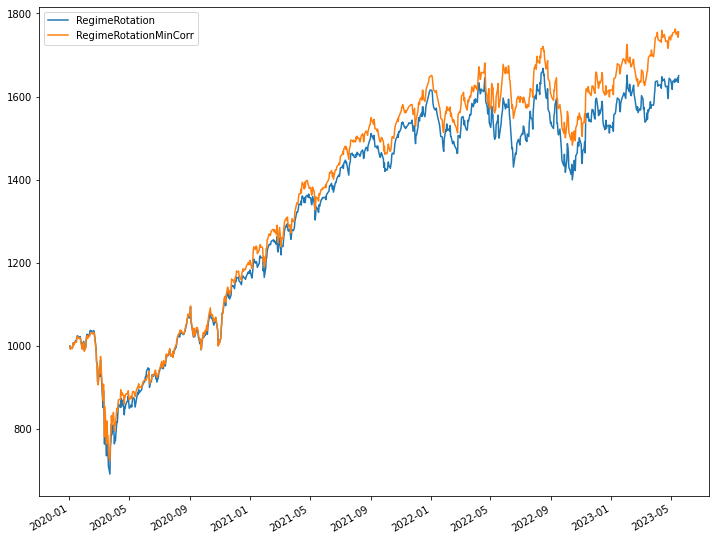

In [42]:
from typing import Optional
from functools import partial
from pandas import DataFrame
import yfinance as yf

from core.strategies import Strategy
from core.signals import OECDUSLEIHP
from core.portfolios import Optimizer


class BacktestManager:
    
    strategies = dict()

    def __init__(self, func):
        self.func = func

    def __call__(
        self,
        prices: DataFrame,
        start: Optional[str] = None,
        end: Optional[str] = None,
        **kwargs,
    ):
        strategy = Strategy(
            prices=prices,
            rebalance=partial(self.func, **kwargs),
            start=start,
            end=end,
        )
        BacktestManager.strategies[self.func.__name__] = strategy
        return strategy

    @classmethod
    def results(cls) -> DataFrame:
        return DataFrame(
            {
                name: strategy.analytics()
                for name, strategy in cls.strategies.items()
            }
        )

    @classmethod
    def get_value(cls) -> DataFrame:
        return DataFrame(
            {name: strategy.value for name, strategy in cls.strategies.items()}
        )



@BacktestManager
def RegimeRotation(strategy, signal):
    state = signal.get_state(str(strategy.date))
    exp_ret = signal.expected_returns_by_states(strategy.reb_prices.iloc[-10 * 252 :])
    index = exp_ret.loc[state].nlargest(5).index
    return Optimizer.from_prices(prices=strategy.reb_prices[index]).uniform_allocation()


@BacktestManager
def RegimeRotationMinCorr(strategy, signal):
    state = signal.get_state(str(strategy.date))
    exp_ret = signal.expected_returns_by_states(strategy.reb_prices.iloc[-10 * 252 :])
    index = exp_ret.loc[state].nlargest(5).index
    return Optimizer.from_prices(
        prices=strategy.reb_prices[index]
    ).minimized_correlation()


@BacktestManager
def EqualWeight(strategy):
    """equal"""
    return Optimizer.from_prices(prices=strategy.reb_prices).uniform_allocation()


@BacktestManager
def Momentum(strategy):
    mom = strategy.reb_prices.iloc[-1] / strategy.reb_prices.iloc[-252]
    index = mom.dropna().nlargest(5).index
    return Optimizer.from_prices(prices=strategy.reb_prices[index]).uniform_allocation()


@BacktestManager
def MinCorr(strategy):
    return Optimizer.from_prices(prices=strategy.reb_prices).minimized_correlation()


@BacktestManager
def MinVol(strategy):
    return Optimizer.from_prices(prices=strategy.reb_prices).minimized_volatility()


@BacktestManager
def RiskParity(strategy):
    return Optimizer.from_prices(prices=strategy.reb_prices).risk_parity()

@BacktestManager
def HRiskParity(strategy):
    return Optimizer.from_prices(prices=strategy.reb_prices).hierarchical_risk_parity()

prices = yf.download(
    tickers="SPY, XLC, XLY, XLP, XLE, XLF, XLV, XLI, XLB, XLRE, XLK, XLU, GLD, BIL"
)["Adj Close"]
start = "2020-1-1"
end = None
signal = OECDUSLEIHP.from_fred_data()
RegimeRotation(prices=prices, signal=signal, start=start, end=end)
RegimeRotationMinCorr(prices=prices, signal=signal, start=start, end=end)
# EqualWeight(prices=prices, start=start, end=end)
# Momentum(prices=prices, start=start)
# MinCorr(prices=prices, start=start)
print(BacktestManager.results())
BacktestManager.value().plot(figsize=(12, 10))

In [44]:
BacktestManager.strategies..value.plot()

AttributeError: type object 'BacktestManager' has no attribute 'RegimeRotationMinCorr'

In [ ]:
import yfinance as yf
from scipy.stats import percentileofscore

prices = yf.download("SPY")["Adj Close"].loc["2018":]

from core.analytics.metrics import to_drawdown

dd = to_drawdown(prices=prices)
p = dd.rolling(126).apply(lambda x: percentileofscore(x, x[-1])) / 100
p = p * p
r = p * 2/(50+1) + (1 - p) * 2/(200+1)
prices.ewm(alpha=r).mean().plot()
# r.plot(figsize=(12, 10))

In [ ]:
p.plot()

In [ ]:
from core import Optimizer
import yfinance as yf


r = Optimizer.from_prices(prices=yf.download("SPY,AGG")["Adj Close"].dropna())

r.minimized_correlation()


In [ ]:
print(r.correlation_matrix)


In [ ]:
from typing import Optional
import pandas as pd
from app.core.strategies import Strategy
from app.core.analytics.features import momentum
from app.core.analytics.metrics import to_ann_volatility


class DualMomentum(Strategy):
    # Objective: balanced growth
    # Type: momentum strategy
    # Invests in: ETFs tracking stocks, bonds, real estate, and gold
    # Rebalancing schedule: monthly
    # Taxation: 50% short-term capital gains
    # Minimum account size: $5,000
    def rebalance(self) -> Optional[pd.Series]:
        single_weight = 1 / (len(self.reb_prices.columns) - 1)
        safe = to_ann_volatility(self.reb_prices.iloc[-252:]).idxmin()
        mome_1y = momentum(self.reb_prices, months=6).iloc[-1]
        safe_mome = mome_1y.loc[safe]
        weights = {}
        for asset in self.reb_prices:
            if asset == safe:
                continue
            if mome_1y.loc[asset] > safe_mome:
                weights.update({asset: single_weight})
            else:
                if safe in weights.keys():
                    weights.update({safe: weights[safe] + single_weight})
                else:
                    weights.update({safe: single_weight})
        return pd.Series(weights)


import yfinance as yf

prices = yf.download("SPY, VNQ, XLK, XLU, XLB, XLV, XLY, XLG, BIL, AGG, TLT")[
    "Adj Close"
]

strategy = DualMomentum(prices=prices).simulate("2015-1-1")

strategy.value.plot()

In [ ]:
from app.core.portfolios import Optimizer
from app.core.strategies import Strategy


class MaxSharpe(Strategy):
    def rebalance(self):
        prices = self.reb_prices.iloc[-252:]
        opt = Optimizer.from_prices(prices)
        return opt.maximized_sharpe_ratio()


import yfinance as yf

prices = yf.download("SPY, VNQ, XLK, XLU, XLB, XLV, XLY, XLG, BIL, AGG, TLT")[
    "Adj Close"
]

prices

In [ ]:
test = prices.copy()
test[~test.isnull()] = 1
test


In [ ]:
from app.core.strategies import HierarchicalEqualRiskContribution
import yfinance as yf

prices = yf.download("SPY, AGG, GSG, TLT")["Adj Close"]

strategy = HierarchicalEqualRiskContribution(prices=prices.dropna()).simulate()

strategy.value


In [ ]:
from src import database as db

with db.SessionContext() as session:
    for (source,) in session.query(db.models.Meta.source).distinct():
        print(source)
        if source == "YAHOO":
            import yfinance as yf

            for meta in (
                session.query(db.models.Meta)
                .filter(db.models.Meta.source == source)
                .all()
            ):
                data = yf.download(
                    tickers=meta.code, start="1980-1-1", progress=False, actions=True
                ).reset_index()
                data.columns = data.columns.str.lower()
                data.columns = data.columns.str.replace(" ", "_")
                data["pri_return"] = (
                    data.close.divide(data.close.shift(1)).subtract(1).fillna(0)
                )
                if "dividends" in data.columns:
                    data["dvd_return"] = data.dividends.divide(
                        data.close.shift(1)
                    ).fillna(0)
                else:
                    data["dvd_return"] = 0
                data["tot_return"] = data["pri_return"].add(data["dvd_return"])
                data = data.assign(meta_id=meta.meta_id)
                print(data)

        elif source == "NAVER":
            import pandas_datareader as pdr

            for meta in (
                session.query(db.models.Meta)
                .filter(db.models.Meta.source == source)
                .all()
            ):
                data = pdr.DataReader(
                    name=meta.code, data_source="naver", start="1980-1-1"
                ).astype(float)
                data = data.reset_index()
                data.columns = data.columns.str.lower()
                data.columns = data.columns.str.replace(" ", "_")
                data["pri_return"] = (
                    data.close.divide(data.close.shift(1)).subtract(1).fillna(0)
                )
                if "dividends" in data.columns:
                    data["dvd_return"] = data.dividends.divide(
                        data.close.shift(1)
                    ).fillna(0)
                else:
                    data["dvd_return"] = 0
                data["tot_return"] = data["pri_return"].add(data["dvd_return"])
                data = data.assign(meta_id=meta.meta_id)
                print(data)
        else:
            data = None

In [ ]:
import pandas as pd

w = pd.read_clipboard(index_col="date")
r = w.stack().astype(float)
r = r.reset_index()
r.columns = ["date", "ticker", "weight"]
r = r[r.weight != 0.0]
r.to_clipboard()

In [ ]:
pd.to_datetime(pd.to_datetime("2022-2-1")).to_pydatetime()

In [ ]:
pd.read_excel(
    config.DATABASE_EXC, sheet_name="tb_meta", parse_dates=["inception_date"]
).sort_values("meta_id")


In [ ]:
import pandas_datareader as pdr
import pandas as pd


def leading_economic_indicator() -> pd.DataFrame:
    """
    Get raw data for leading economic indicator regime.
    """
    tickers = dict(USALOLITONOSTSAM="USLEI")
    data = (
        pdr.DataReader(list(tickers.keys()), "fred", start="1900-01-01")
        .resample("M")
        .last()
    )
    data = data.rename(columns=tickers)
    return data[["USLEI"]]


leading_economic_indicator()

In [ ]:
from src.core import metrics


import pandas as pd

nav = pd.read_clipboard(index_col="date", parse_dates=True)
nav

In [ ]:
metrics.to_max_drawdown(nav).to_clipboard()

In [ ]:
(
    prices / prices.resample("D").last().ffill().shift(1, freq=pd.DateOffset(months=1))
).dropna()


In [ ]:
prices.pct_change(21)

In [ ]:
import pandas as pd

pri_returns = prices.pct_change()
latest_date = pri_returns.index[-1]
start_date = latest_date + pd.DateOffset(years=5)
start_date

In [ ]:
from src import db


db.create_all()

In [ ]:
import pandas as pd

pr_date = prices.index[-1] - pd.DateOffset(years=1)

prices.iloc[-1] / prices.iloc[prices.index.get_loc(pr_date)] - 1


In [ ]:
import pandas_datareader as pdr


price = pdr.DataReader("329200", "naver", start="2021-4-1")
price.to_csv("329200.csv")


In [ ]:
import json

import pandas as pd
from sec_api import QueryApi
from sec_api import ExtractorApi
from src.config import EDGAR_API

queryApi = QueryApi(api_key=EDGAR_API)

query = {
    "query": {
        "query_string": {
            "query": "ticker:TSLA",
        }
    },
    "from": "200",
    "size": "300",
    "sort": [{"filedAt": {"order": "desc"}}],
}

response = queryApi.get_filings(query)


metadata = pd.DataFrame.from_records(response["filings"])

print(metadata)


# extractorApi = ExtractorApi(EDGAR_API)


# sections_10_k = {
#     "1": "Business",
#     "1A": "Risk Factors",
#     "1B": "Unresolved Staff Comments",
#     "2": "Properties",
#     "3": "Legal Proceedings",
#     "4": "Mine Safety Disclosures",
#     "5": "Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities",
#     "6": "Selected Financial Data (prior to February 2021)",
#     "7": "Management’s Discussion and Analysis of Financial Condition and Results of Operations",
#     "7A": "Quantitative and Qualitative Disclosures about Market Risk",
#     "8": "Financial Statements and Supplementary Data",
#     "9": "Changes in and Disagreements with Accountants on Accounting and Financial Disclosure",
#     "9A": "Controls and Procedures",
#     "9B": "Other Information",
#     "10": "Directors, Executive Officers and Corporate Governance",
#     "11": "Executive Compensation",
#     "12": "Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters",
#     "13": "Certain Relationships and Related Transactions, and Director Independence",
#     "14": "Principal Accountant Fees and Services",
# }


# for id, f in enumerate(response["filings"]):
#     if f["formType"] == "10-K":
#         url_10k = f["linkToFilingDetails"]

#         out = {}

#         for sec, des in sections_10_k.items():
#             out[des] = extractorApi.get_section(url_10k, sec, "text")

#         filename = f"{id}.json"

#         with open(filename, "w") as f:
#             json.dump(out, f)


In [ ]:
metadata.to_csv("test.csv")


In [ ]:
response["filings"][0]["linkToTxt"]


In [ ]:
# 8-K example
url_8k = "https://www.sec.gov/Archives/edgar/data/66600/000149315222016468/form8-k.htm"

item_1_1_text = extractorApi.get_section(
    response["filings"][0]["linkToTxt"], "1-1", "text"
)
item_1_1_text

In [ ]:
stra = strategy.HierarchicalEqualRiskContribution(prices=prices).simulate(
    start="2015-1-1"
)
stra.value.plot()
# weights_bm = prices.notna().divide(prices.notna().sum(axis=1), axis=0)
# metrics.to_pri_return(prices=prices).multiply(weights_bm).sum(axis=1).loc["2015-1-1":].add(1).cumprod().multiply(1000).plot()
stra.analytics()


In [ ]:
from src import db


with db.SessionContext() as session:
    query = session.query(db.models.Meta)

    result = list(record.to_dict() for record in query.all())

print(result)


In [ ]:
import pandas as pd

pd.DataFrame(result)

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# create line chart trace
line_trace = go.Scatter(
    x=stra.value.index, y=stra.value.values, mode="lines", name=stra.value.name
)

# create stacked bar chart traces
bar_traces = []
for col in stra.allocations.columns:
    trace = go.Bar(x=stra.allocations.index, y=stra.allocations[col] * 100, name=col)
    bar_traces.append(trace)

# create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# add line chart to the first subplot with its own legend
fig.add_trace(line_trace, row=1, col=1)
fig.update_traces(showlegend=True, row=1, col=1)

# add stacked bar chart to the second subplot with its own legend
for trace in bar_traces:
    fig.add_trace(trace, row=2, col=1)
    fig.update_traces(showlegend=True, row=2, col=1)

# update chart layout and style
fig.update_layout(
    title="My Beautiful Subplots",
    xaxis_title="Date",
    yaxis_title="Values",
    template="plotly_dark",
    hovermode="x unified",
    showlegend=True,
    legend=dict(
        x=0.5,
        y=1.2,
        orientation="h",
        xanchor="center",
        yanchor="bottom",
        bordercolor="white",
        borderwidth=1,
        bgcolor="white",
        font=dict(size=12),
    ),
    font=dict(family="Arial", size=12, color="black"),
    barmode="stack",
    # add legends for subplots
    annotations=[
        dict(
            x=0.5,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<b>Line Chart</b>",
            font=dict(size=14),
            align="center",
        ),
        dict(
            x=0.5,
            y=0.6,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<b>Stacked Bar Chart</b>",
            font=dict(size=14),
            align="center",
        ),
    ],
)

# show the chart
fig.show()


In [ ]:
from src.core.portfolios import Optimizer
import yfinance as yf

prices = yf.download("SPY, AGG, GSG, TLT")["Adj Close"]
opt = Optimizer.from_prices(prices=prices)
opt.hierarchical_equal_risk_contribution()

In [ ]:
opt.hierarchical_risk_parity()

In [ ]:
opt.maximized_sharpe_ratio()